In [1]:
import numpy as np
from astropy.table import Table
import treecorr
import h5py
import matplotlib.pyplot as plt

def div0( a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c
def read_Data_hdf5(fname,col_dict,cuts,key):
    dat=Table.read(fname,path=key)
    cuts=open(cuts)
    for line in cuts:
        dat=dat[eval(line)]

def read_Data(fname1,col_dict,cuts,key=None):
    data_file=h5py.File(fname1,'r')
    dat=Table()
    for i,v in col_dict.items():
        if key!=None and v!=None:
            dat[i]=data_file[key][v]
        elif key==None and v!=None:
            dat[i]=data_file[v]
        else:
            dat[i]=None
    cuts=open(cuts)
    for line in cuts:
        dat=dat[eval(line)]
    return dat

def noPadding(table, primary_key):
    return table[table[primary_key]!=0]

def projShapeCal(table):
    ax=table['ax']
    ay=table['ay']
    q=table['q']
    phi=np.arctan2(ay,ax)
    e1=np.divide(1-q,1+q)*np.cos(2*phi)
    e2=np.divide(1-q,1+q)*np.sin(2*phi)
    table['e1']=e1
    table['e2']=e2
    return table

def NG(table,rand_pcounts,sightBins,nbins,min_sep,max_sep,rpar_step):
    table=noPadding(table,'ax')
    table=projShapeCal(table)
    catG=treecorr.Catalog(x=table['x'],y=table['y'],z=table['z'],g1=table['e1'],g2=table['e2'])
    NGCor=list()
    for i in np.arange(sightBins):
        NGCor.append(treecorr.NGCorrelation(nbins=nbins,min_sep=min_sep,max_sep=max_sep,metric="Rperp",
                                            min_rpar=i*rpar_step,max_rpar=(i+1)*rpar_step))
        NGCor[i].process(catG,catG)
    NG_ksi=np.zeros((sightBins,nbins))
    for i in np.arange(sightBins):
        NG_ksi[i]=div0(NGCor[i].npairs,rand_pcounts[i])
    NG_w=np.sum(NG_ksi,axis=0)
    return NG_w

def NN(table,rand_cat,sightBins,nbins,min_sep,max_sep,rpar_step):
    catN=treecorr.Catalog(x=table['x'],y=table['y'],z=table['z'])
    NNCor=list()
    NRCor=list()
    RRCor=list()
    for i in np.arange(sightBins):
        NNCor.append(treecorr.NNCorrelation(nbins=nbins,min_sep=min_sep,max_sep=max_sep,metric="Rperp",
                                               min_rpar=i*rpar_step,max_rpar=(i+1)*rpar_step))
        NRCor.append(treecorr.NNCorrelation(nbins=nbins,min_sep=min_sep,max_sep=max_sep,metric="Rperp",
                                               min_rpar=i*rpar_step,max_rpar=(i+1)*rpar_step))
        RRCor.append(treecorr.NNCorrelation(nbins=nbins,min_sep=min_sep,max_sep=max_sep,metric="Rperp",
                                               min_rpar=i*rpar_step,max_rpar=(i+1)*rpar_step))
        NNCor[i].process(catN)
        NRCor[i].process(catN,rand_cat)
        RRCor[i].process(rand_cat)
    for i in np.arange(sightBins):
        print(colors[i%len(colors)])
        plt.plot(np.arange(10),rand_pairs[i]/rand_pairs[1], label=str(i),c=colors[i%len(colors)])
    #plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()
    xi=np.zeros((nbins,sightBins))
    varxi=np.zeros((nbins,sightBins))
    for i in np.arange(sightBins):
        xi[:,i],varxi[:,i]=NNCor[i].calculateXi(RRCor[i],NRCor[i])
    xi_tot=np.sum(xi,axis=1)
    varxi_tot=np.sum(varxi,axis=1)
    return xi_tot,varxi_tot

def RR(table,scale,min_box,max_box,sightBins,nbins,min_sep,max_sep,rpar_step,cat_out=False):
    rand=np.random.uniform(min_box,max_box,size=len(table['x'])*scale*3)
    rand=np.random.permutation(rand)
    rand=rand.reshape(3,len(table['x'])*scale)
    dat=Table()
    dat['x']=rand[0]
    dat['y']=rand[1]
    dat['z']=rand[2]
    print(dat)
    catR=treecorr.Catalog(x=rand[0],y=rand[1],z=rand[2])
    if cat_out==True:
        return catR
    RRCor=list()
    rand_pcounts=np.zeros((sightBins,nbins))
    for i in np.arange(sightBins):
        RRCor.append(treecorr.NNCorrelation(nbins=nbins,min_sep=min_sep,max_sep=max_sep,metric="Rperp",
                                            min_rpar=i*rpar_step,max_rpar=(i+1)*rpar_step))
        RRCor[i].process(catR)
        rand_pcounts[i]=RRCor[i].npairs
    return rand_pcounts

def corFunc(fname1,col_name,cuts,sightBins,rscale,nbins,min_sep,max_sep,rpar_step,min_box,max_box,func,
            fname2=None,col_name2=None,key=None,key2=None,cuts2=None):
    data=read_Data(filename,col_names,cuts,fname2,col_name2,key,key2,cuts2)
    if func=='NN':
        catR=RR(data,rscale,min_box,max_box,sightBins,nbins,min_sep,max_sep,rpar_step,cat_out=True)
        xi,varxi=NN(data,catR,sightBins,nbins,min_sep,max_sep,rpar_step)
        return xi,varxi
    if func=='NG':
        data=noPadding(data,'ax')
        rand_pairs=RR(data,rscale,min_box,max_box,sightBins,nbins,min_sep,max_sep,rpar_step)
        NG_w=NG(data,rand_pairs,sightBins,nbins,min_sep,max_sep,rpar_step)
        return NG_w
    

/home/hmarti21/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete
Data add iteration complete


/home/hmarti21/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


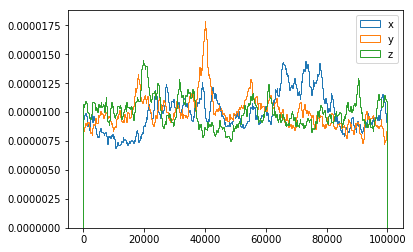

Cut Complete
Cut Complete
   x       y       z         mass      ...     bx         by     e1   e2 
------- ------- ------- -------------- ... ---------- --------- ---- ----
80268.7 99671.4 25807.6 100001000000.0 ...    0.43678  0.899568 None None
40295.5 46269.0 67389.8 100004000000.0 ...   0.647372  0.762174 None None
59526.4 51338.5 86888.1 100005000000.0 ...   0.217971  0.975955 None None
20039.9 73559.1 97095.4 100009000000.0 ...   0.257856  0.966183 None None
96779.9 11491.7 95975.4 100011000000.0 ...   0.504452   0.86344 None None
70452.2 81578.7 47314.4 100011000000.0 ...  -0.591576   0.80625 None None
31347.6 60973.2 72130.5 100024000000.0 ...   0.538967  0.842327 None None
31644.5 84107.0 94685.6 100028000000.0 ...  -0.413231  0.910626 None None
18036.5 52967.0 60244.7 100028000000.0 ...  -0.464353   0.88565 None None
24200.4 59266.5 13190.7 100039000000.0 ...   -0.98129 -0.192536 None None
    ...     ...     ...            ... ...        ...       ...  ...  ...
70061.3 8170

In [2]:
filename='Downloads/data_sukhdeep.hdf5'
col_names={'x':'halos.x','y':'halos.y','z':'halos.z','mass':'halos.mass','q':'shapesStar.q2d','ax':'shapesStar.a2d_x','ay':'shapesStar.a2d_y','bx':'shapesStar.b2d_x','by':'shapesStar.b2d_y','e1':None,'e2':None}
cuts='/home/hmarti21/cuts.txt'
sightBins=5
rscale=1
nbins=10
min_sep=1000
max_sep=10000
rpar_step=10000
min_box=0
max_box=100000
key='hydro_full'
#NG_w=corFunc(filename,col_names,cuts,sightBins,rscale,nbins,min_sep,max_sep,rpar_step,min_box,max_box,'NG',key='hydro_full')
data=read_Data(filename,col_names,cuts,key=key)
#data=Table.read('Downloads/data_sukhdeep.hdf5',path='hydro_full')
#data=read_Data_hdf5(filename,col_names,cuts,key)
print(data)

In [3]:
data=noPadding(data,'ax')
print(data)

   x       y       z         mass      ...     bx         by     e1   e2 
------- ------- ------- -------------- ... ---------- --------- ---- ----
80268.7 99671.4 25807.6 100001000000.0 ...    0.43678  0.899568 None None
40295.5 46269.0 67389.8 100004000000.0 ...   0.647372  0.762174 None None
59526.4 51338.5 86888.1 100005000000.0 ...   0.217971  0.975955 None None
20039.9 73559.1 97095.4 100009000000.0 ...   0.257856  0.966183 None None
96779.9 11491.7 95975.4 100011000000.0 ...   0.504452   0.86344 None None
70452.2 81578.7 47314.4 100011000000.0 ...  -0.591576   0.80625 None None
31347.6 60973.2 72130.5 100024000000.0 ...   0.538967  0.842327 None None
31644.5 84107.0 94685.6 100028000000.0 ...  -0.413231  0.910626 None None
18036.5 52967.0 60244.7 100028000000.0 ...  -0.464353   0.88565 None None
24200.4 59266.5 13190.7 100039000000.0 ...   -0.98129 -0.192536 None None
    ...     ...     ...            ... ...        ...       ...  ...  ...
70061.3 81706.5 45077.0 995092000000.0

In [4]:
rand_pairs=RR(data,rscale,min_box,max_box,sightBins*2,nbins,min_sep,max_sep,rpar_step)
print(rand_pairs)

        x                  y                  z         
------------------ ------------------ ------------------
3619.6882135941855   43909.4067589341  37741.25671430644
 68302.52815316521  37093.65440484317  92096.13923448023
  77420.7437867356 20683.180436526116 2026.3205197879274
 97011.29540139019  48318.50529122034 27122.911477606416
 61273.47227902963  38229.38277442166  87494.24483339708
57987.385644002454   70196.9351372456  60136.55801785629
15471.344777768669  90392.19832260613  7165.641182695604
 72977.98369780513  95336.66391196738  26959.53831144773
 35670.41929825957 15563.651229775676  21510.12657115091
 67647.98096603055     94587.88740024  28769.19927604338
               ...                ...                ...
  81173.6848854816 1925.3263905041563  42747.32019337272
 88028.04552238034  77424.51232262947  88555.80493022689
 96014.31071261088  90260.29603459335  49415.50618926458
 88584.92618134421  37940.95909186139  81405.32550344078
 79792.86995780314 48343.671046

/home/hmarti21/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


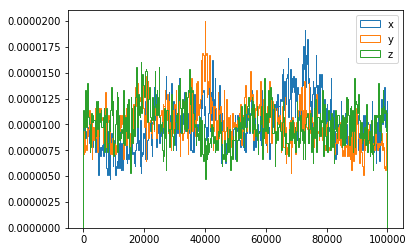

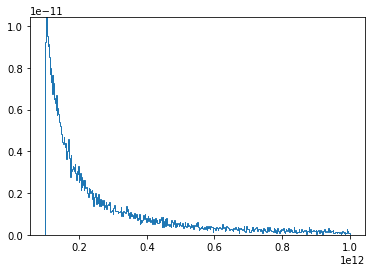

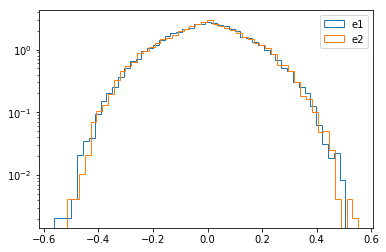

   x       y       z    ...           e1                    e2         
------- ------- ------- ... --------------------- ---------------------
80268.7 99671.4 25807.6 ...  0.045540883252344094  -0.05786640866212007
40295.5 46269.0 67389.8 ...  0.027245588663591083  -0.16615198143776783
59526.4 51338.5 86888.1 ...    0.1660308940591618   -0.0780566599719043
20039.9 73559.1 97095.4 ...    0.2323475932907569   -0.1335290487718459
96779.9 11491.7 95975.4 ...   0.06477399520972396  -0.11490818147691093
70452.2 81578.7 47314.4 ...  0.062406753368093704   0.19838521232738673
31347.6 60973.2 72130.5 ...    0.1784330015607849   -0.3866371960192471
31644.5 84107.0 94685.6 ...   0.06119938754570114   0.06994674680980667
18036.5 52967.0 60244.7 ...   0.07356927979183836   0.10639317826243667
24200.4 59266.5 13190.7 ...  -0.16899655050172147   -0.0689718467039342
    ...     ...     ... ...                   ...                   ...
70061.3 81706.5 45077.0 ...   -0.1971061146660596   0.3283377151

In [5]:
NG_w,NG_pairs=NG(data,rand_pairs,sightBins*2,nbins,min_sep,max_sep,rpar_step)

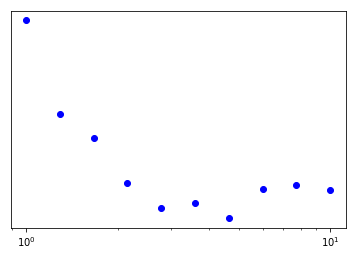

In [6]:
plt.errorbar(np.logspace(0,1,10),NG_w,fmt='bo')

plt.xscale('log')
plt.yscale('log')

In [7]:
import seaborn as sns

In [8]:
colors=sns.color_palette()

[[  8177.  12760.  20325.  31221.  48355.  74508. 113143. 171951. 259541.
  392857.]
 [  7533.  11907.  18749.  29751.  46235.  73092. 114542. 179771. 282144.
  441033.]
 [  6461.  10322.  16197.  25558.  39968.  62658.  99629. 155505. 246536.
  389423.]
 [  5431.   8583.  13623.  21257.  33559.  53388.  83716. 131011. 206893.
  327555.]
 [  4561.   7123.  11213.  17672.  27768.  43545.  67957. 107691. 169824.
  268894.]
 [  3566.   5744.   8795.  14015.  22024.  34802.  54955.  85783. 135594.
  214794.]
 [  2677.   4525.   6835.  11030.  17517.  27222.  42620.  67161. 105006.
  166230.]
 [  2063.   3346.   5114.   8127.  12863.  20108.  31616.  49118.  77401.
  121926.]
 [  1435.   2208.   3519.   5518.   8759.  13761.  22019.  34398.  53626.
   85137.]
 [   938.   1474.   2319.   3785.   5787.   9078.  14385.  22698.  35461.
   55484.]]


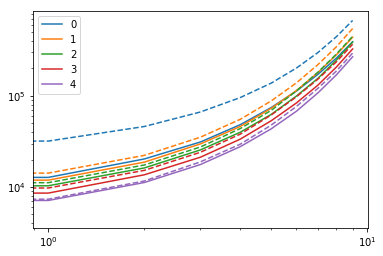

In [9]:
print(rand_pairs)

for i in np.arange(5):

    plt.plot(np.arange(10),rand_pairs[i], label=str(i),c=colors[i])
    plt.plot(np.arange(10),NG_pairs[i], ls='--',c=colors[i])
plt.yscale('log')
plt.xscale('log')
# plt.plot(np.arange(10),rand_pairs[1], label='rand1')
# plt.plot(np.arange(10),rand_pairs[2], label='rand2') #--
# plt.plot(np.arange(10),rand_pairs[3], label='rand3') #--
# plt.plot(np.arange(10),rand_pairs[4], label='rand4') #--
# plt.plot(np.arange(10),NG_pairs[0], label='shape0', ls='--')
# plt.plot(np.arange(10),NG_pairs[1], label='shape1', ls='--')
# plt.plot(np.arange(10),NG_pairs[2], label='shape2', ls='--')
# plt.plot(np.arange(10),NG_pairs[3], label='shape3', ls='--')
# plt.plot(np.arange(10),NG_pairs[4], label='shape4', ls='--')
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[0]))
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[1]))
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[2]))
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[3]))
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[4]))
#plt.plot(np.arange(10),div0(NG_pairs[0],rand_pairs[0]), label='divide')
plt.legend()

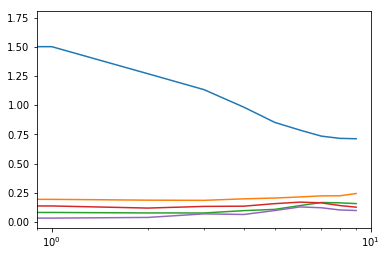

In [10]:
for i in np.arange(5):

    plt.plot(np.arange(10),NG_pairs[i]/rand_pairs[i]-1, label=str(i),c=colors[i])
# plt.yscale('log')
plt.xscale('log')


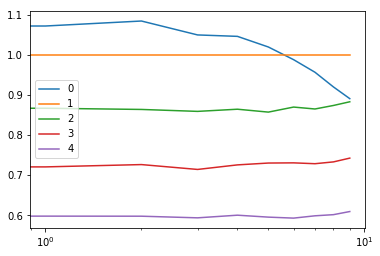

In [11]:
for i in np.arange(5):

    plt.plot(np.arange(10),rand_pairs[i]/rand_pairs[1], label=str(i),c=colors[i])
# plt.yscale('log')
plt.xscale('log')
plt.legend()

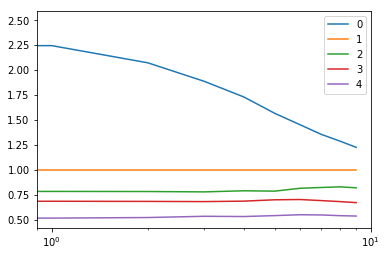

In [12]:
for i in np.arange(5):

    plt.plot(np.arange(10),NG_pairs[i]/NG_pairs[1], label=str(i),c=colors[i])
# plt.yscale('log')
plt.xscale('log')
plt.legend()

In [19]:
#NN
catR=RR(data,rscale*10,min_box,max_box,sightBins*20,nbins,min_sep,max_sep,rpar_step,cat_out=True)

        x                  y                  z         
------------------ ------------------ ------------------
 70430.63391974579  58854.52195502162  97545.31287925872
 7718.467505837623  96785.26142767906  75762.29550915165
  44772.0453956063 10000.096985591677  71575.75692239174
 87524.65840494717  65817.67018289887 24835.586830668886
 74743.71612725218 24224.689758539163 22702.152387374575
 42681.15205629716   49980.6230564677    81361.947313277
4178.1540457852425  93938.55519633298  46726.10904803621
 91794.49336276343   82626.0792179725  73530.88284624624
 84095.00656824005 24678.656989673298  92533.38258576381
25011.524974007625 31456.080875500058  54242.36070501296
               ...                ...                ...
 99434.06401664196  57139.63125579766  41972.90276856405
 91744.22957189083  43264.84893330724  36835.43605137161
 58709.30483155491  93725.97433178131  94259.74130077485
 77064.86979778779 13191.709701317022  99060.60128683032
 90538.08491720264  85346.43109

[ 20330.  29115.  41651.  59457.  84306. 118727. 169043. 242814. 351167.
 511000.]
[  86385.  137262.  215451.  341747.  542264.  859851. 1362771. 2171408.
 3457833. 5514398.]
[  827335.  1291384.  2014330.  3135108.  4849568.  7487199. 11529923.
 17729485. 27146179. 41334021.]
...
[  8923.  14210.  22246.  35250.  55347.  87848. 138257. 217540. 338414.
 531060.]
[  77925.  123822.  194482.  307976.  487944.  775279. 1229059. 1953271.
 3129229. 5007903.]
[  754103.  1192071.  1882400.  2970434.  4691029.  7422394. 11758122.
 18657397. 29598730. 46740270.]
...
[  7257.  11162.  17449.  27524.  43847.  69410. 113597. 181393. 286621.
 449188.]
[  67957.  107342.  171024.  270796.  427166.  677851. 1079267. 1718083.
 2749888. 4398906.]
[  649722.  1025674.  1620446.  2557280.  4040290.  6393726. 10147907.
 16144533. 25751370. 41088939.]
...
[  6259.   9760.  15244.  24089.  38098.  61767.  97934. 152472. 235989.
 369048.]
[  57952.   91035.  143474.  227231.  358860.  569230.  905979. 1448

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
...


IndexError: index 10 is out of bounds for axis 0 with size 10

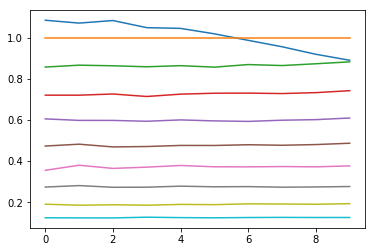

In [20]:
xi,varxi=NN(data,catR,sightBins*20,nbins,min_sep,max_sep,rpar_step)

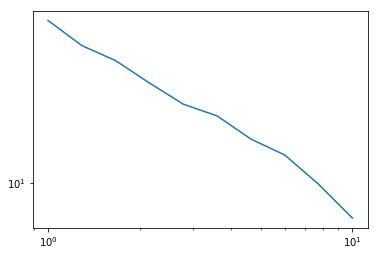

In [15]:
plt.plot(np.logspace(0,1,10), xi)
plt.xscale('log')
plt.yscale('log')

In [16]:
bins=np.logspace(0,1,11)

In [17]:
bin_center=0.5*(bins[1:]+bins[:-1])